In this project I'll show how to make portfolio optimisation for the given assets. Assets could vary from single stocks to ETFs or mutual fund data.

I'll feed the program with the returns of given assets and it will give me the weights of the optimal portfolio using the 'Efficient Frontier' approach. First let's start with some information on the portfolio optimization techniques and the one I'll be using for this project.

Portfolio optimization is the process of selecting a combination of investments that maximize returns for a given level of risk or minimize risk for a given level of return. It is a central component of modern finance and is used to help investors make informed decisions about how to allocate their assets.

There are several best practice techniques for portfolio optimization that have been developed over the years by financial experts and academics. Some of the most widely used techniques include:

Markowitz Portfolio Optimization: Developed by Harry Markowitz in the 1950s, this is one of the earliest and most widely used techniques for portfolio optimization. It involves using statistical methods to determine the optimal combination of assets that provide the highest expected return for a given level of risk, or the lowest risk for a given level of return.

Black-Litterman Model: This model is an extension of the Markowitz model and takes into account the views and opinions of the investor when determining the optimal portfolio. It allows the investor to specify their own expected returns for different assets, which can be used to adjust the optimal portfolio.

Mean-Variance Optimization: This technique is similar to the Markowitz model and involves optimizing the portfolio by minimizing the variance of the portfolio's returns while also maximizing expected return.

Risk Parity Portfolio: This portfolio construction technique seeks to allocate assets such that each asset contributes equally to the portfolio's overall risk. This can result in a more balanced and diversified portfolio.

Maximum Diversification Portfolio: This portfolio construction technique seeks to maximize the diversification of the portfolio by maximizing the number of uncorrelated assets in the portfolio.

Minimum Variance Portfolio: This portfolio construction technique seeks to minimize the portfolio's overall risk by selecting the combination of assets that have the lowest expected risk.

In this project I'll be using Markowitz Portfolio Optimization and using the 'Efficient Frontier' approach.

The steps one should go over when optimizing a portfolio with this method are as the following:

-Estimation of expected returns: The expected returns for each asset in the portfolio are estimated based on historical data or other sources of information.

-Calculation of covariance matrix: The covariance between the returns of different assets is calculated to determine the risk associated with holding a portfolio of assets.

-Construction of the efficient frontier: The efficient frontier is constructed by plotting the expected returns and standard deviations of all possible portfolios and selecting the portfolios that offer the highest expected return for a given level of risk, or the lowest risk for a given level of return.

-Portfolio selection: The portfolio that lies on the efficient frontier that provides the highest expected return for a given level of risk, or the lowest risk for a given level of return, is selected as the optimal portfolio.

A note on assumptions: It is important to note that Markowitz Portfolio Optimization makes certain assumptions, such as the normality of asset returns and the constancy of covariances over time. While these assumptions are reasonable in many cases, they may not always hold, so it is important to be aware of the limitations of the model when using it for portfolio optimization.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the data into a pandas DataFrame

df = pd.read_excel('annual_returns.xlsx', sheet_name='Sheet2',index_col=0)
# df = pd.read_excel("annual_returns.xlsx")
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
df[numeric_cols.columns] = numeric_cols / 100
#print(df)

# Calculate mean and variance of returns for each asset
mean_returns = df.mean()
cov_matrix = df.cov()

print('Mean: \n' ,mean_returns)
print('Cov_matrix: \n ' ,cov_matrix)



Mean: 
 IPV     0.309381
GOLD    0.060630
dtype: float64
Cov_matrix: 
             IPV      GOLD
IPV   0.055562 -0.005683
GOLD -0.005683  0.014970


Weights are as follows:
{'IPV': 0.2521828801352053, 'GOLD': 0.7478171198647947}
Expected return: 0.12
Volatility: 0.10


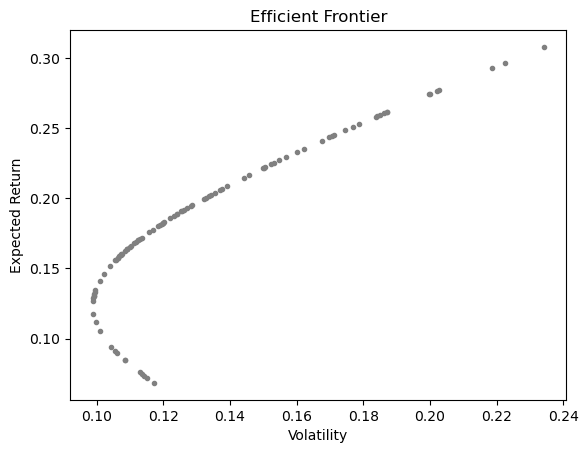

In [74]:

# Number of assets
num_assets = len(mean_returns)

# Define objective function for optimization
def portfolio_variance(weights):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Define constraint that weights must sum to 1 and can't be negative
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda x: x})


# Define bounds for weights (between 0 and 1)
bounds = tuple((0, 1) for i in range(num_assets))

# Define initial guess for weights (equal weights)
init_guess = [1/num_assets] * num_assets

# Use scipy minimize function to optimize portfolio
efficient_portfolio = minimize(portfolio_variance, init_guess, method='SLSQP', 
                               constraints=constraints, bounds=bounds)

# Extract weights of efficient portfolio
asset_names = list(df.columns)
weights = efficient_portfolio.x

weights_dict = dict(zip(asset_names,weights))
print('Weights are as follows:')
print(weights_dict)

# Calculate returns and volatility of efficient portfolio
portfolio_return = np.dot(weights.T, mean_returns)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Print results
# print(f'Weights: {weights}')
print(f'Expected return: {portfolio_return:.2f}')
print(f'Volatility: {portfolio_volatility:.2f}')


# Plot efficient frontier
portfolio_returns = []
portfolio_volatilities = []
for i in range(100):
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)
    portfolio_returns.append(np.dot(weights.T, mean_returns))
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)
plt.scatter(portfolio_volatilities, portfolio_returns, marker='.', color='gray')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.show()
